In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

https://www.kaggle.com/code/fredblair/transformers-for-stocks

https://keras.io/examples/timeseries/timeseries_classification_transformer/

In [4]:
stock_data=pd.read_csv('aapl_data.csv')

In [5]:
# Data explore

stock_data.head()

,date,open,high,low,close,volume
0,3/1/2013,15.643,15.649,15.356,15.374,552447168
1,3/4/2013,15.279,15.293,14.964,15.002,582737596
2,3/5/2013,15.053,15.543,15.027,15.398,638428168
3,3/6/2013,15.518,15.545,15.158,15.202,460249076
4,3/7/2013,15.161,15.429,15.038,15.378,468471304


Text(0, 0.5, 'Prices ($)')

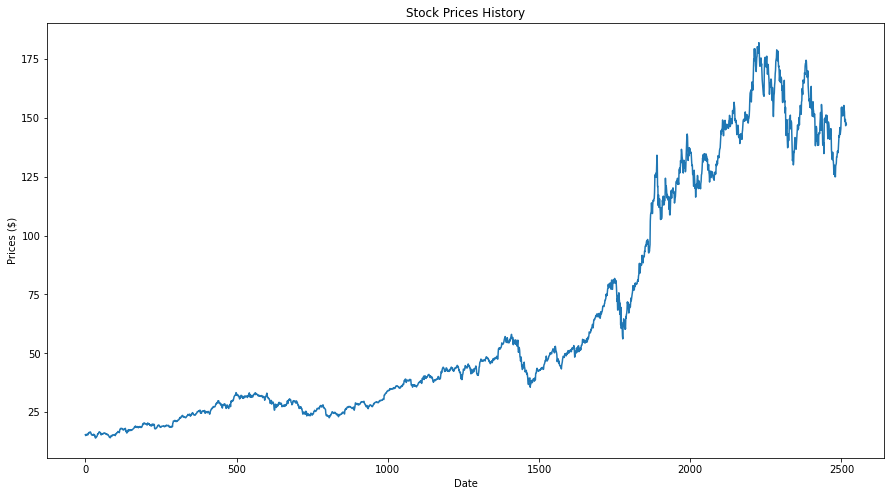

In [6]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

# Data Processing

In [7]:
close_prices = stock_data['close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)
#Scaling the training set
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]



x_train = []
y_train = []

timestep=10

for i in range(timestep, len(train_data)):
    x_train.append(train_data[i-timestep:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
x_train[0],y_train[0]

(array([[0.00848496],
        [0.0062715 ],
        [0.00862777],
        [0.00746153],
        [0.00850876],
        [0.00875272],
        [0.01005581],
        [0.0080506 ],
        [0.00803275],
        [0.00891338]]), 0.011287501041282386)

In [9]:
x_train.shape,y_train.shape

((2004, 10, 1), (2004,))

In [18]:
test_data = scaled_data[training_data_len-timestep:, : ]
x_test = []
y_test = values[training_data_len:]

for i in range(timestep, len(test_data)):
  x_test.append(test_data[i-timestep:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [11]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)


In [12]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3

In [13]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [14]:
input_shape = x_train.shape[1:]
print(input_shape)

(10, 1)


In [15]:
model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

In [16]:

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
#model.summary()


history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=callbacks,
)

Epoch 1/100
81/81 [==============================] - 27s 35ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0691 - val_mean_squared_error: 0.0691 - lr: 1.0000e-06
Epoch 2/100
81/81 [==============================] - 2s 28ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - lr: 3.4300e-05
Epoch 3/100
81/81 [==============================] - 2s 23ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.7558e-04 - val_mean_squared_error: 9.7558e-04 - lr: 6.7600e-05
Epoch 4/100
81/81 [==============================] - 2s 22ms/step - loss: 8.4512e-04 - mean_squared_error: 8.4512e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - lr: 1.0090e-04
Epoch 5/100
81/81 [==============================] - 2s 23ms/step - loss: 6.4113e-04 - mean_squared_error: 6.4113e-04 - val_loss: 7.4490e-04 - val_mean_squared_error: 7.4490e-04 - lr: 1.3420e-04
Epoch 6/100
81/81 [==============================] - 2s 23ms/step - loss

# Evaluate model

In [19]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

16/16 [==============================] - 1s 12ms/step


0.4014371352451704

<ipython-input-20-16c375ac7934>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


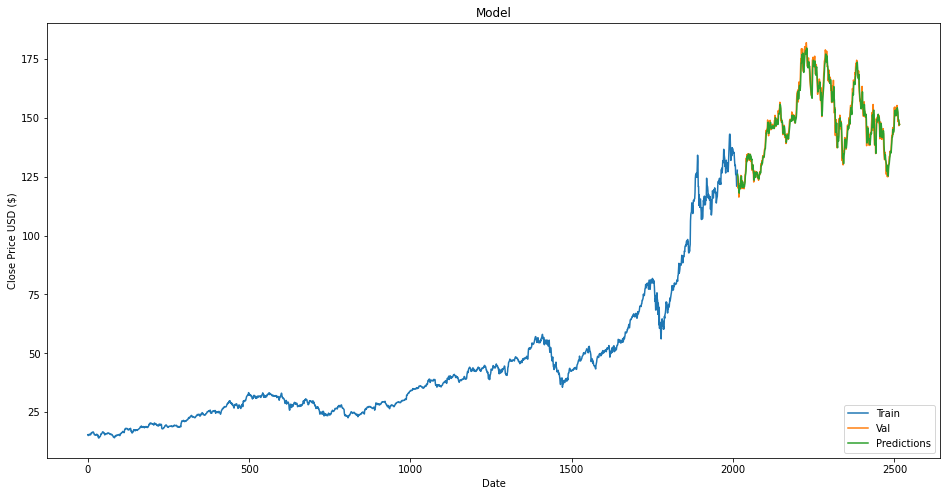

In [20]:
data = stock_data.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
stock_data.tail()

,date,open,high,low,close,volume
2512,2/22/2023,148.87,149.95,147.16,148.91,51011305
2513,2/23/2023,150.09,150.34,147.24,149.40,48394249
2514,2/24/2023,147.11,147.19,145.72,146.71,55469606
2515,2/27/2023,147.71,149.17,147.45,147.92,44998470
2516,2/28/2023,147.05,149.08,146.83,147.41,50546998


In [22]:
validation

,close,Predictions
2014,125.12,126.043007
2015,122.06,125.283875
2016,120.13,123.046898
2017,121.42,120.953323
2018,116.36,121.180054
...,...,...
2512,148.91,149.526291
2513,149.40,148.971313
2514,146.71,148.870651
2515,147.92,147.061356
